# Correlation Image

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
import mpld3

In [2]:
import neuralyzer
from neuralyzer.im import smff

In [3]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (8,8)

In [4]:
datafile = '/Users/michael/coding/RIKEN/data/140316/data5/data2/Image_0001_0001_channel1_testdata.tif'
#datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel0.tif'
#datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel1_testdata.tif'
data = neuralyzer.get_data(datafile)

[ 2015-04-20 10:54:31 ] [ log ] [ INFO ] : NEURALYZER LOGGER CREATED
[ 2015-04-20 10:54:31 ] [ log ] [ DEBUG ] : stdoutloglevel: DEBUG
[ 2015-04-20 10:54:31 ] [ data_handler ] [ DEBUG ] : root_path set to /Users/michael/coding/RIKEN/lib/neuralyzer/notebooks/dev
[ 2015-04-20 10:54:31 ] [ data_handler ] [ DEBUG ] : loaded data from cache file: /Users/michael/coding/RIKEN/data/140316/data5/data2/Image_0001_0001_channel1_testdata.tif.hdf5


In [5]:
datashape = data.shape
data = data.reshape((data.shape[0], data.shape[1]*data.shape[2])).T
data.shape

(65536, 1000)

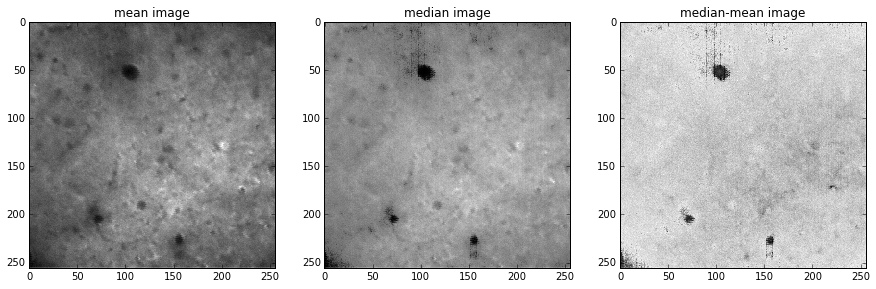

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
meanim = np.mean(data, axis=1).reshape(256,256)
ax[0].imshow(meanim)
ax[0].set_title('mean image')
medianim = np.median(data, axis=1).reshape(256,256)
ax[1].imshow(medianim)
ax[1].set_title('median image')
ax[2].imshow(medianim-meanim)
ax[2].set_title('median-mean image')

In [7]:
def get_neighbours_1D(x, size):
    if x >= size:
        raise ValueError('x is bigger than size allows.')
    if x == 0:
        xn = [x, x+1]
    elif x == size-1:
        xn = [x-1, x]
    else:
        xn = [x-1, x, x+1]
    return xn
        

def get_neighbours_2D(x,y, imsize):
    mask = np.zeros(imsize)
    xn = get_neighbours_1D(x, imsize[0])
    yn = get_neighbours_1D(y, imsize[1])
    ns = [(xi, yi) for xi in xn for yi in yn]
    ns.remove((x,y))
    return ns


def mask_neighbours(x, y, imshape):
    mask = np.zeros(imshape, dtype='uint8')
    for (xi, yi) in get_neighbours_2D(x, y, imshape):
        mask[xi, yi] = 1
    return mask.astype('bool')


def mask_random_pixels(N, imshape):
    '''
    N is just the number of times a pixel is drawn.
    If N gets close to the total number of pixels N will definitely not 
    be the number of maskes pixels!
    '''
    mask = np.zeros(imshape, 'uint8').flatten()
    mask[np.random.randint(len(mask)-1, size=(10, 1))] = 1
    return mask.reshape(imshape[0], imshape[1]).astype('bool')

In [8]:
def normalize_imagestack(ims):
    ''' Normalize it! What else?
    '''
    ims = ims.copy()
    N, y, x = ims.shape
    ims = ims.reshape(N, y*x)
    ims = ims - np.tile(ims.mean(axis=0), (ims.shape[0], 1))
    ims = ims /np.tile(ims.std(axis=0), (ims.shape[0], 1))
    return ims.reshape(N,y,x)



def correlation_image(imagestack):
    ''' A function that calculates a correlation image from an image stack.
    
    The correlation image is calculated for each pixels by computing 
    the mean correlation of the pixel with its neighbouring pixels.
    
    @arguments: imagestack with dims [N, y, x]
    @returns: correlationimage
    '''
    N, y, x = imagestack.shape
    npix = y*x
    ims = normalize_imagestack(imagestack)
    ims = ims.reshape(N,npix)
    cim = np.zeros((x,y))
    for idx in range(npix):
        (xi, yi) = int(idx/x), np.mod(idx, x)
        nm = mask_neighbours(xi, yi, (x,y)).flatten()
        cim[xi, yi] = np.dot(ims[:, idx], ims[:, nm]).mean()
    return cim

In [9]:
ims = data.T.reshape(1000, 256, 256).copy()

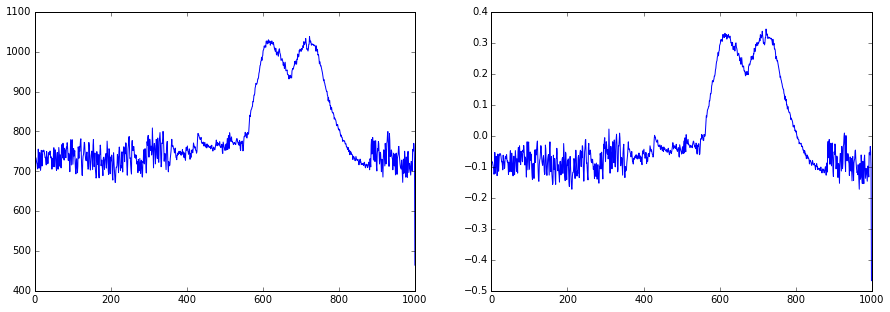

In [10]:
ims_norm = normalize_imagestack(ims)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].plot(ims.reshape(1000, 65536).mean(axis=1))
ax[1].plot(ims_norm.reshape(1000, 65536).mean(axis=1))

In [11]:
corrim = correlation_image(ims)

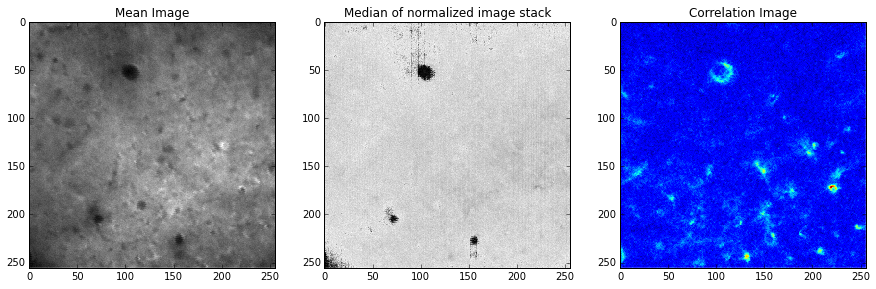

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].imshow(ims.mean(axis=0))
ax[0].set_title('Mean Image')
ax[1].imshow(np.median(ims_norm,axis=0))
ax[1].set_title('Median of normalized image stack')
ax[2].imshow(corrim, cmap='jet')
ax[2].set_title('Correlation Image')